In [4]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import backend as K

In [2]:
# 데이터 불러오기
train_df = pd.read_csv('./dts/train.csv')
test_df = pd.read_csv('./dts/test.csv')
sample_submission_df = pd.read_csv('./dts/sample_submission.csv')

# ID 열 제거
train_df = train_df.drop('ID', axis=1)
test_df = test_df.drop('ID', axis=1)

# Weight_Status, Gender 열을 숫자 데이터로 변환
train_df['Weight_Status'] = train_df['Weight_Status'].map({'Normal Weight': 0, 'Overweight': 1, 'Obese': 2})
train_df['Gender'] = train_df['Gender'].map({'M': 0, 'F': 1})
test_df['Weight_Status'] = test_df['Weight_Status'].map({'Normal Weight': 0, 'Overweight': 1, 'Obese': 2})
test_df['Gender'] = test_df['Gender'].map({'M': 0, 'F': 1})

# PolynomialFeatures를 사용하여 데이터 전처리
poly = PolynomialFeatures(degree=2, include_bias=False)
X = poly.fit_transform(train_df.drop('Calories_Burned', axis=1))
y = train_df['Calories_Burned']

# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train, valid 데이터 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [5]:
X_train.shape

(5250, 54)

In [3]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [39]:
from tensorflow import keras

model = Sequential()

model.add(Dense(32, activation='relu', input_shape=(None,54)))
model.add(Dense(1))

model.compile(loss=rmse, optimizer='adam')

chk_callback = keras.callbacks.ModelCheckpoint(filepath='./tmp/md.h5', save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
hist = model.fit(X_train, y_train, epochs=1000, validation_data=(X_valid, y_valid), callbacks=[chk_callback])

Epoch 1/1000
165/165 [==============================] - 1s 1ms/step - loss: 104.1090 - val_loss: 95.0061
Epoch 2/1000
165/165 [==============================] - 0s 757us/step - loss: 78.6812 - val_loss: 58.1013
Epoch 3/1000
165/165 [==============================] - 0s 733us/step - loss: 37.2957 - val_loss: 21.2240
Epoch 4/1000
165/165 [==============================] - 0s 747us/step - loss: 17.1975 - val_loss: 13.8521
Epoch 5/1000
165/165 [==============================] - 0s 810us/step - loss: 11.9220 - val_loss: 9.8381
Epoch 6/1000
165/165 [==============================] - 0s 730us/step - loss: 8.8533 - val_loss: 7.6477
Epoch 7/1000
165/165 [==============================] - 0s 763us/step - loss: 6.9558 - val_loss: 6.1513
Epoch 8/1000
165/165 [==============================] - 0s 758us/step - loss: 5.7702 - val_loss: 5.1899
Epoch 9/1000
165/165 [==============================] - 0s 761us/step - loss: 4.8502 - val_loss: 4.4034
Epoch 10/1000
165/165 [==============================] -

<Figure size 15000x20000 with 0 Axes>

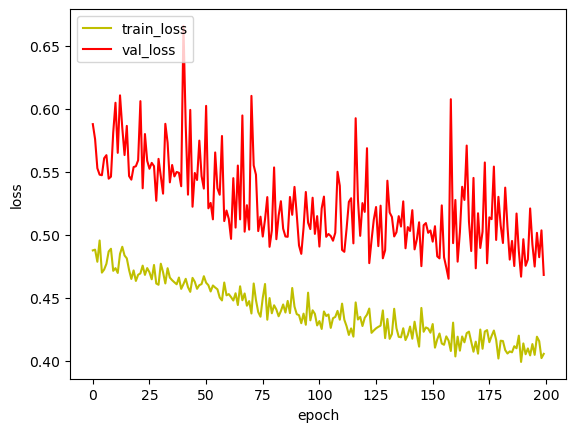

In [40]:
import matplotlib.pyplot as plt


plt.figure(figsize=(150,200))
fig, ax = plt.subplots()

ax.plot(hist.history['loss'][200:400], 'y', label='train_loss')
ax.plot(hist.history['val_loss'][200:400], 'r', label='val_loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss')

ax.legend(loc='upper left')

plt.show()

In [41]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, None, 32)          1760      
                                                                 
 dense_24 (Dense)            (None, None, 1)           33        
                                                                 
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________


In [24]:
# valid 데이터 예측 및 평가
y_pred_valid = model.predict(X_valid)
rmse_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
print(f"Valid 데이터 RMSE: {rmse_valid:.3f}")

71/71 [==============================] - 0s 414us/step
Valid 데이터 RMSE: 0.484


In [31]:
md_new = keras.models.load_model('tmp/md.h5')
y_pred_valid = md_new.predict(X_valid)
rmse_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
print(f"Valid 데이터 RMSE: {rmse_valid:.3f}")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xac in position 38: invalid start byte